In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

100% 242M/242M [00:05<00:00, 45.2MB/s]
100% 242M/242M [00:05<00:00, 43.2MB/s]


In [ ]:
#unzipping zip
from zipfile import ZipFile
file_name = 'amazon-fine-food-reviews.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zips:
  zips.extractall()
  print('Done')

Done


In [ ]:
#libraries used in the model: pandas
#reading csv file
import pandas as pd

def read_file_chunks(_):
  if _ ==0:
    return pd.read_csv('Reviews.csv', index_col=0, chunksize =10000)
  elif _==1:
    return pd.read_csv('new_file_Reviews.csv', chunksize =10000)
  else:
    return pd.read_csv('Summary_Text_Sentiment.csv', chunksize =10000)

In [ ]:
#reading first chunk
df =read_file_chunks(0)

In [ ]:
#checking our DataFrame
next(df).head()
# df.shape
# df.columns

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
10000,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
10001,10001,B000P41A28,A3K3GNZWUYXRUT,L. Bream,3,6,5,1214697600,If you're worried about consitpation....,I purchased this formula but was worried after...,1
10002,10002,B000P41A28,AFAWC4ZJ29YV1,AG,1,3,1,1334102400,THIS IS NOT ORGANIC!!! TOXIC hexane still in it!,RECONSIDER THIS FORMULA!!<br /><br />Martek ad...,-1
10003,10003,B000P41A28,AVUV2TE9UKTPU,asianprincess,4,10,1,1285545600,shipping time is unreasonably long,"i ordered this on 8/29/10, and it didn't ship ...",-1
10004,10004,B000P41A28,A2MWGBNJRJN57M,Organic Mommy,1,5,1,1282953600,Horribly Constipating,My child was exclusively breastfed for 4 1/2 m...,-1


In [ ]:
#self analysis : can ignore this cell
# horrible, 
df =read_file_chunks(0)

pd.set_option("display.max_colwidth", 2)
i=0
for data in df:
  i +=10000
  # good =data['Summary'].str.find("wonderful")
  # good_bad =data[good >0]['Score'] ==1
  # print(data.loc[good_bad[good_bad ==True].index]['Summary'])
  # if i ==250000:
  #   print(data.loc[244580])
  print(data[data['Summary'] =='These "Butter Leaves" are addictively wonderful!'][['Score', 'Text']])

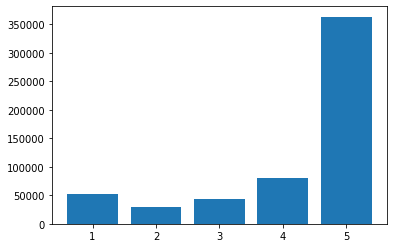

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualizing the data
import matplotlib.pyplot as plt

dic ={'1':0, '2':0, '3':0, '4':0, '5':0}

def sore_count(obj):
  dic['1'] +=obj[obj ==1].count()
  dic['2'] +=obj[obj ==2].count()
  dic['3'] +=obj[obj ==3].count()
  dic['4'] +=obj[obj ==4].count()
  dic['5'] +=obj[obj ==5].count()

for chunk in df:
  chunk[['Score']].apply(sore_count)

plt.bar(dic.keys(), dic.values())
plt.show()
plt.clf()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


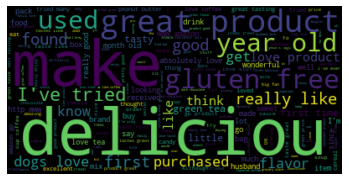

In [ ]:
#make a wordcloud for entire data
df =read_file_chunks(0)

#removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
STOPWORDS =stopwords.words()
# print(len(stopwords.words('english')))

#find more stopwords
# for chunk in df:
#   print(chunk[chunk['Text'].str.find('<a') >0])

#stopwords to add : <br />, <p>, </p>, <a, href
#after run add stopwords : 'use', 'got', 'th', 'ordered', 'bought'
STOPWORDS.extend(['br', '<p>', '</p>', '<a', 'href', 'use', 'got', 'th', 'ordered', 'bought'])
# print(STOPWORDS)

#extracting non stopwords from 'Text' column
text = " ".join(chunk.Text.to_string() for chunk in df)
wordcloud =WordCloud(stopwords=STOPWORDS).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
df =read_file_chunks(0)
#we use header only once i.e. at the start i.e. on the first chunk
#if we forget this header will be appended at every chunk.
#Therefore increasing number of records

header =True
for chunk in df:
  chunk['Sentiment'] = np.where(chunk['Score']<=2, -1, chunk['Score'])
  chunk['Sentiment'] = np.where(chunk['Sentiment']==3, 0, chunk['Sentiment'])
  chunk['Sentiment'] = np.where(chunk['Sentiment']>=4, 1, chunk['Sentiment'])
  #first delete then append
  chunk.to_csv("new_file_Reviews.csv",index =False, header =header, mode='a')
  header =False

df =read_file_chunks(1)
next(df).head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,-1
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


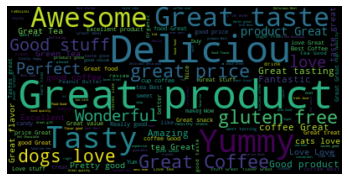

In [ ]:
#good reviews
df =read_file_chunks(1)
text = " ".join(chunk[chunk['Sentiment'] ==1].Summary.to_string() for chunk in df)
wordcloud =WordCloud(stopwords=STOPWORDS).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

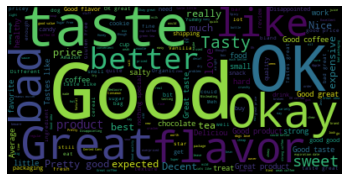

In [ ]:
#neutral reviews
df =read_file_chunks(1)
text = " ".join(chunk[chunk['Sentiment'] ==0].Summary.to_string() for chunk in df)
wordcloud =WordCloud(stopwords=STOPWORDS).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

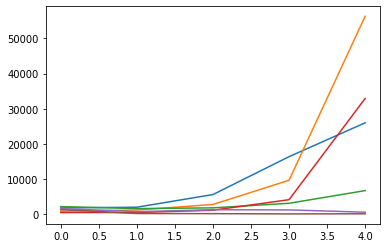

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualizing data wrt words
import seaborn as sns
words ={'good': [0]*5, 'great': [0]*5, 'like': [0]*5, 'love': [0]*5, 'bad': [0]*5, 'horrible': [0]*5}
i =0

def word_search(obj):
  #getting obj from score =1 to score =5 i.e. asc order
  # print(obj)
  global words, i
  for key, values in words.items():
    # print(i, obj)
    # print(obj.index[obj.str.lower().str.find(key) >=0].tolist())
    words[key][i] +=obj[obj.str.lower().str.find(key) >=0].count()
  i +=1

df =read_file_chunks(0)

for chunk in df:
  i =0
  chunk.groupby('Score')['Summary'].agg(word_search)
  # break

# df_words =pd.DataFrame(words)
# df_words.head()
# for key, values in words.items():
#   plt.plot(values)
# plt.show()
# plt.clf()
words

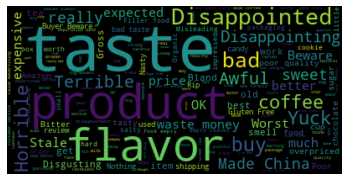

In [ ]:
#bad reviews
df =read_file_chunks(1)
STOPWORDS.extend(['good', 'great', 'like', 'love'])
text = " ".join(chunk[chunk['Sentiment'] ==-1].Summary.to_string() for chunk in df)
wordcloud =WordCloud(stopwords=STOPWORDS).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#identifying if Summary or Text is null
df =read_file_chunks(1)
for chunk in df:
  print(chunk[chunk.Summary.isna()].Score)

In [ ]:
#removing punctuations and getting the data that we will work on ready in file
df =read_file_chunks(1)
STOPWORDS = [word for word in STOPWORDS if word not in ['good', 'great', 'like', 'love']]
def remove_punctuation(text):
    # print(text)
    final = "".join(u for u in str(text) if u not in ("?", ".", ";", ":",  "!",'"'))
    return final

#why use header...see new_file_Reviews creation in above cells
header =True
for chunk in df:
  chunk['Text'] = chunk['Text'].apply(remove_punctuation)
  chunk = chunk.dropna(subset=['Summary'])
  chunk['Summary'] = chunk['Summary'].apply(remove_punctuation)
  chunk[['Sentiment', 'Summary', 'Text']].to_csv("Summary_Text_Sentiment.csv",index =False, header =header, mode='a')
  header =False

In [ ]:
#checking if files have consistant records
df =read_file_chunks(2)
i=0
for chunk in df:
  i +=chunk.shape[0]

print(i)
print(len(STOPWORDS))

In [ ]:
df =read_file_chunks(2)
next(df).head(10)

In [ ]:
#Train & Test split
from sklearn.model_selection import train_test_split

df =read_file_chunks(2)
#X is data and Y is target
header =True
for chunk in df:
  X_train, X_test, Y_train, Y_test =train_test_split(chunk['Summary'],
                                                     chunk['Sentiment'],
                                                     test_size =.2,
                                                     random_state =21,
                                                     stratify =chunk['Sentiment']
                                                     )
  X_train.to_csv("X_train.csv",index =False, header =header, mode='a')
  X_test.to_csv("X_test.csv",index =False, header =header, mode='a')
  Y_train.to_csv("Y_train.csv",index =False, header =header, mode='a')
  Y_test.to_csv("Y_test.csv",index =False, header =header, mode='a')
  header =False

In [ ]:
#deleting unnecessary files
import os
os.remove("Summary_Text_Sentiment.csv")
os.remove("new_file_Reviews.csv")
os.remove("Reviews.csv")

In [ ]:
#access X_train, X_test, Y_train, Y_test in chunks
def read_xy_chunk(file_name):
  return pd.read_csv(file_name, chunksize =10000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train =pd.read_csv("X_train.csv")
test =pd.read_csv("X_test.csv")
train_matrix = vectorizer.fit_transform(train['Summary'].astype('str'))
test_matrix = vectorizer.transform(test['Summary'].astype('str'))

In [ ]:
# count vectorizer:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import confusion_matrix,classification_report

# vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# def func(text):
  # k =[word for word in text]
  # text ="".join(str(text.values))
  # final = "".join(u for u in str(text) if u not in ("'"))
  # return final

# Y_train = read_xy_chunk('Y_train.csv')
# X_train = read_xy_chunk('X_train.csv')
# for chunk, y in zip(X_train, Y_train):
  # print(chunk.apply(func))
  # break chunk.apply(func)
  # train_matrix =vectorizer.fit_transform(chunk.Summary.values.astype('str'))
  # print(vectorizer.get_feature_names())
  # print(train_matrix.toarray())
  # print(train_matrix.shape, y.shape)
#   lr.fit(train_matrix, y['Sentiment'])

# X_test = read_xy_chunk('X_test.csv')
# Y_test = read_xy_chunk('Y_test.csv')

# for chunk, y in zip(X_test, Y_test):
#   test_matrix =vectorizer.fit_transform(chunk.Summary.values.astype('str'))
#   predictions = lr.predict(chunk.Summary.values.astype('str'))
#   new = np.asarray(y)
#   print(confusion_matrix(predictions,y))
# print(train_matrix)

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
X_train = train_matrix
X_test = test_matrix
y_train = pd.read_csv("Y_train.csv")['Sentiment']
y_test = pd.read_csv("Y_test.csv")['Sentiment']

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[10631,  1907,  2045],
       [  612,  1920,   949],
       [ 5162,  4699, 85761]])

In [ ]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.65      0.73      0.69     14583
           0       0.23      0.55      0.32      3481
           1       0.97      0.90      0.93     95622

    accuracy                           0.86    113686
   macro avg       0.61      0.73      0.65    113686
weighted avg       0.90      0.86      0.88    113686



In [ ]:
arr =vectorizer.transform(['These "Butter Leaves" are addictively wonderful!'])
predictions = lr.predict(arr)
print(predictions)

[1]


In [ ]:
# !pip install django==1.11.17
# !apt install python3.7
# !python3.7 --version

#fitting model
X_train = train_matrix
X_test = test_matrix
Y_train = pd.read_csv('Y_train.csv')
Y_test = read_xy_chunk('Y_test.csv')

# for X_chunk, Y_chunk in zip(X_train, Y_train):
#   print(X_chunk)
# print(X_train.shape, Y_train.shape)
lr.fit(X_train, Y_train)

In [ ]:
#making prediction 
predictions = lr.predict(X_test)